In [94]:
# Import necessary libraries
import pandas as pd
import numpy as np
from pycaret.classification import *

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
from matplotlib.colors import ListedColormap


from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA

from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso, ElasticNet
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from pycaret.regression import *
from sklearn.metrics import silhouette_samples, silhouette_score
import math
import random
import matplotlib.ticker as mtick
import re

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

from neighborhoods import admin_wards
from neighborhoods import district_neighborhoods

In [95]:
random.seed(42)

In [96]:
# Load the dataset
df = pd.read_csv('../data/processed/scraped_data_cleaned_ER.csv')
df = df.dropna()
df.shape

(1066, 15)

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1066 entries, 0 to 1065
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price                  1066 non-null   int64  
 1   house_type             1066 non-null   object 
 2   house_type_2           1066 non-null   object 
 3   rooms                  1066 non-null   int64  
 4   m2                     1066 non-null   float64
 5   elevator               1066 non-null   int64  
 6   garage                 1066 non-null   int64  
 7   neighborhood           1066 non-null   object 
 8   district               1066 non-null   object 
 9   sports_centers         1066 non-null   float64
 10  social_wellness_index  1066 non-null   float64
 11  urban_mobility_index   1066 non-null   float64
 12  education_index        1066 non-null   float64
 13  employment_index       1066 non-null   float64
 14  health_index           1066 non-null   float64
dtypes: f

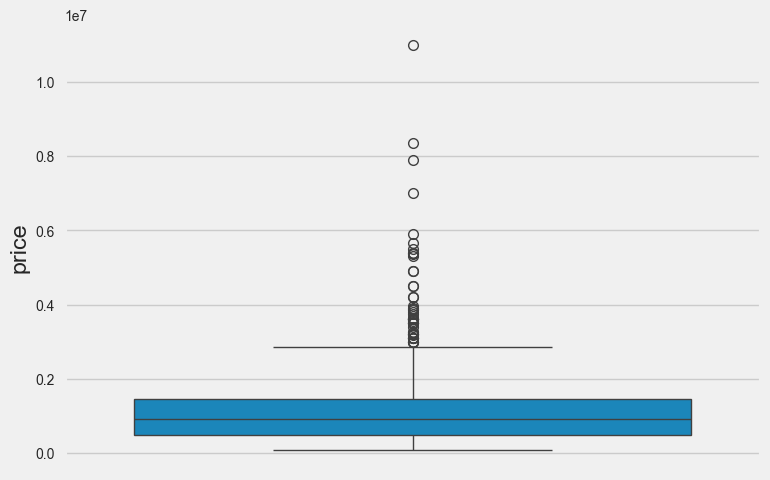

In [98]:
sns.boxplot(df['price'])
plt.show()

In [99]:
import warnings
warnings.filterwarnings("ignore")

In [100]:
df.columns

Index(['price', 'house_type', 'house_type_2', 'rooms', 'm2', 'elevator',
       'garage', 'neighborhood', 'district', 'sports_centers',
       'social_wellness_index', 'urban_mobility_index', 'education_index',
       'employment_index', 'health_index'],
      dtype='object')

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1066 entries, 0 to 1065
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price                  1066 non-null   int64  
 1   house_type             1066 non-null   object 
 2   house_type_2           1066 non-null   object 
 3   rooms                  1066 non-null   int64  
 4   m2                     1066 non-null   float64
 5   elevator               1066 non-null   int64  
 6   garage                 1066 non-null   int64  
 7   neighborhood           1066 non-null   object 
 8   district               1066 non-null   object 
 9   sports_centers         1066 non-null   float64
 10  social_wellness_index  1066 non-null   float64
 11  urban_mobility_index   1066 non-null   float64
 12  education_index        1066 non-null   float64
 13  employment_index       1066 non-null   float64
 14  health_index           1066 non-null   float64
dtypes: f

In [102]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

In [103]:
df_corr = pd.DataFrame(df[numerical_features].corr()['price'])
df_corr['price'] = df_corr['price'].apply(lambda x: abs(x))
df_corr.sort_values(by='price', ascending=False)

,price
price,1.00
m2,0.79
rooms,0.49
employment_index,0.31
garage,0.26
education_index,0.20
urban_mobility_index,0.15
elevator,0.13
sports_centers,0.13
health_index,0.05


In [104]:
# Define features and target variable
X = df[[column for column in df.columns if column != 'price']]
y = df['price']

In [105]:
# Identify numerical and categorical columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

# Define preprocessing for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with the mean
    ('scaler', StandardScaler())  # Standardize numerical features
])

# Define preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with the most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [106]:
# cluster_errors = []

# for n_clusters in range(2, 11):
#     kmeans_pipeline = Pipeline([
#         ('preprocessor', preprocessor),
#         ("pca", PCA(10, svd_solver='arpack')),
#         ("cluster", KMeans(n_clusters=n_clusters, random_state=42, verbose=0))
#     ])
#     kmeans_pipeline.fit(X)
#     wcsse = kmeans_pipeline.named_steps["cluster"].inertia_
#     print('K = ', n_clusters, '\tWCSS Err. = ', wcsse)
#     cluster_errors.append(wcsse)

# plt.plot(range(2, 11), cluster_errors, "o-")
# plt.xlabel("No. Clusters")
# plt.ylabel("SSE")
# plt.show()

In [107]:
# silhouette_s = []

# for n_clusters in range(2, 11):
#     kmeans_pipeline = Pipeline([
#         ('preprocessor', preprocessor),
#         ("pca", PCA(10, svd_solver='arpack')),
#         ("cluster", KMeans(n_clusters=n_clusters))])
#     df_X = kmeans_pipeline.fit_transform(X)
#     cluster_labels = kmeans_pipeline.fit_predict(X)
#     print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_score(df_X, cluster_labels).round(4))
#     silhouette_s.append(silhouette_score(df_X, cluster_labels))

# plt.plot(range(2, 11),silhouette_s, "o-")
# plt.xlabel("No. Clusters")
# plt.ylabel("Silhouette Score")
# plt.show()


In [108]:
pipe_pca_kmean = Pipeline(
        [
          ('preprocessor', preprocessor),
          ("cluster", KMeans(n_clusters=2, verbose=0))
        ]
    )
pipe_pca_kmean.fit(X)
pipe_pca_kmean.predict(X)

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [109]:
kmean_cluster = pd.DataFrame(
    data = pipe_pca_kmean.named_steps["cluster"].labels_,
    index = X.index,
    columns=['kmean_cluster']
)

In [110]:
kmean_cluster


,kmean_cluster
0,0
1,0
2,0
3,0
4,0
...,...
1061,1
1062,1
1063,0
1064,0


In [111]:
kmean_cluster['kmean_cluster'].value_counts()

0    742
1    324
Name: kmean_cluster, dtype: int64

In [112]:
X['kmean_cluster'] = kmean_cluster['kmean_cluster'].copy()

In [113]:
df['kmean_cluster'] = kmean_cluster['kmean_cluster'].copy()

In [114]:
df['price'] = df['price'].apply(lambda x: round(x, 2))
pd.options.display.float_format = '{:.2f}'.format

df_combined_describe_dict = {}
columns = []

df_0 = df[df['kmean_cluster']==0]
df_0_y_describe = df_0['price'].describe()
df_combined_describe_dict['df_0'] = df_0_y_describe
columns.append(('Price', 'Cluster 0'))

df_1 = df[df['kmean_cluster']==1]
df_1_y_describe = df_1['price'].describe()
df_combined_describe_dict['df_1'] = df_1_y_describe
columns.append(('Price', 'Cluster 1'))

# df_2 = df[df['kmean_cluster']==2]
# df_2_y_describe = df_2['price'].describe()
# df_combined_describe_dict['df_2'] = df_2_y_describe
# columns.append(('Price', 'Cluster 2'))

df_combined_describe = pd.DataFrame(df_combined_describe_dict)

multi_index = pd.MultiIndex.from_tuples(columns)

df_combined_describe.columns = multi_index

df_combined_describe

Price           
        Cluster 0  Cluster 1
count      742.00     324.00
mean   1311628.97  774578.99
std    1078676.04  603314.40
min     141000.00   89000.00
25%     629000.00  299000.00
50%    1090000.00  655000.00
75%    1650000.00 1099250.00
max   11000000.00 3650000.00

In [115]:
tsne = Pipeline(
        [
          ('preprocessor', preprocessor),
          ("tsne", TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, init='random')),
        ]
    )

X_tsne = tsne.fit_transform(X)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1066 samples in 0.000s...
[t-SNE] Computed neighbors for 1066 samples in 0.034s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1066
[t-SNE] Computed conditional probabilities for sample 1066 / 1066
[t-SNE] Mean sigma: 1.469453
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.600105
[t-SNE] KL divergence after 1000 iterations: 0.441487


In [116]:
le = LabelEncoder()

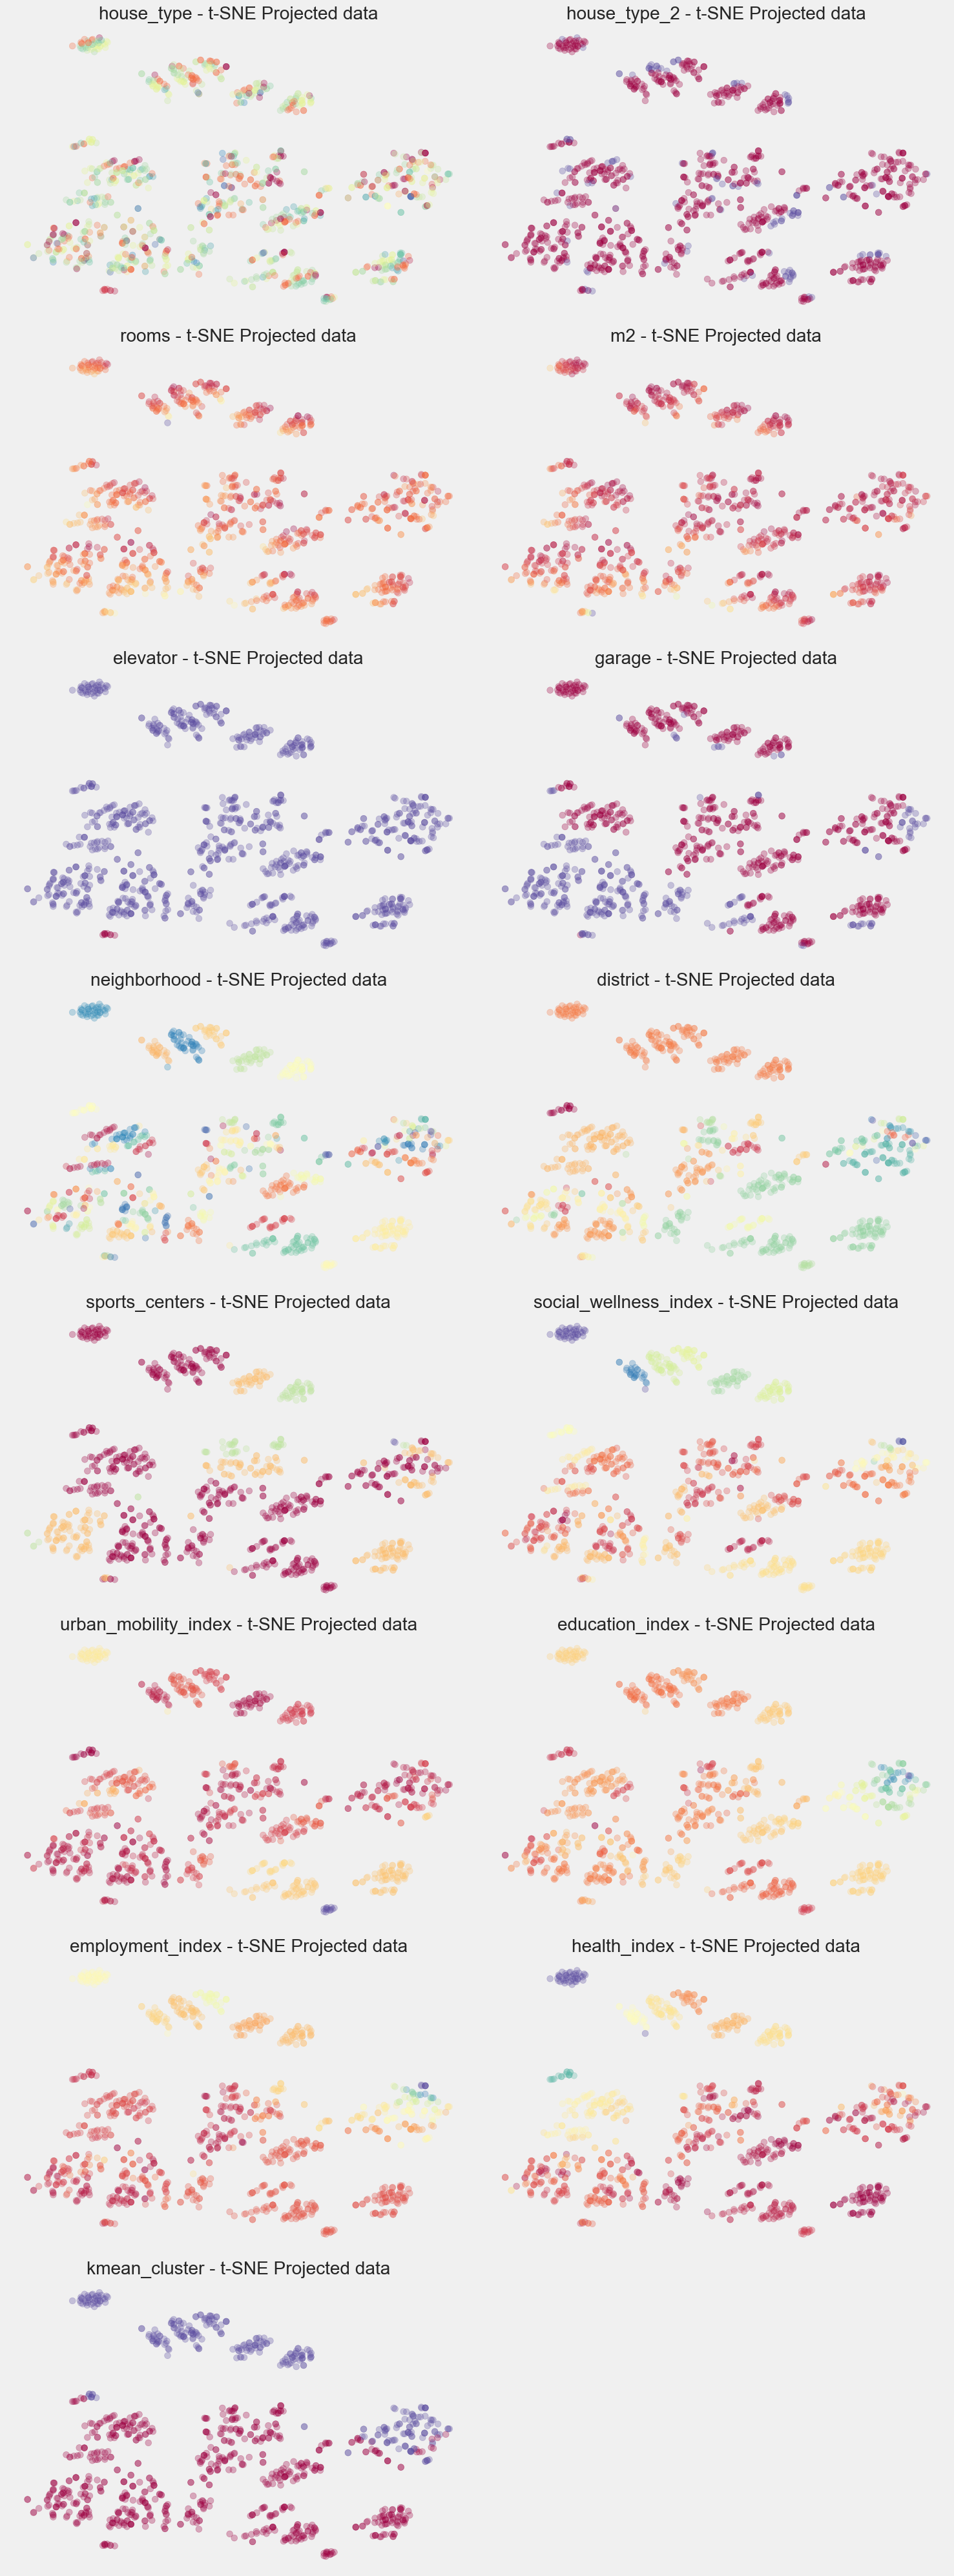

In [117]:
nrows = 16
ncols = 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize = (15, 5*nrows))

axs = axs.flatten()

le = LabelEncoder()

cluster_colors = ['#69ACD9', '#E8917D', '#E2C480']
custom_cmap = ListedColormap(cluster_colors)

for i, column in enumerate(X.columns):
    if i >= len(axs):
        break
    ax = axs[i]
    if column in categorical_features:
        encoded_column = le.fit_transform(df[column])
        scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=encoded_column, cmap=plt.cm.Spectral, alpha=0.3)
    else:
        scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df[column], cmap=plt.cm.Spectral, alpha=0.3)

    ax.set_title(f'{column} - t-SNE Projected data')
    ax.axis('tight')
    ax.set_xticks([])
    ax.set_yticks([])

for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


In [118]:
num_features_plot = ['price', 'm2']

In [119]:
def plot_clusters(column, df_list, numerical_features, figsize, rotate=False):
    print(rotate)
    if column in numerical_features:
        fig = plt.figure(figsize=(10, 5))
        ax = fig.add_subplot(111)
        for i, df in enumerate(df_list):
            sns.kdeplot(data=df, x=column, ax=ax, label=f'Cluster {i}', shade=True)
        ax.set_title(f'KDE Plot - {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Density')
        ax.legend()
        if rotate:
            plt.xticks(rotation=360)
    else:
        cluster_colors = ['#69ACD9', '#E8917D', '#E2C480']
        combined_df = pd.concat([df.assign(cluster=i) for i, df in enumerate(df_list)])
        proportions = combined_df.groupby([column, 'cluster']).size().reset_index(name='count')
        proportions['proportion'] = proportions.groupby(column)['count'].apply(lambda x: x / float(x.sum()))
        pivot_df = proportions.pivot(index=column, columns='cluster', values='proportion').fillna(0)
        pivot_df = pivot_df.sort_values(by=0)
        fig, ax = plt.subplots(figsize=figsize)
        pivot_df.plot(kind='bar', stacked=True, ax=ax, color=cluster_colors[:pivot_df.shape[1]])
        ax.set_title(f'Relative Proportions - {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Proportion')
        ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
        if rotate:
            plt.xticks(rotation=90)
        else:
            plt.xticks(rotation=0)
    plt.show()

False


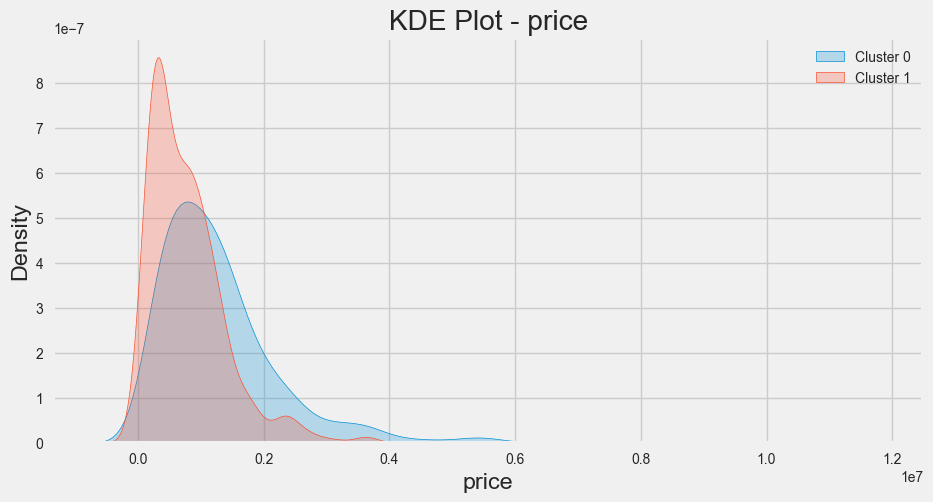

In [120]:
plot_clusters('price', [df_0, df_1], num_features_plot, (10,5))

False


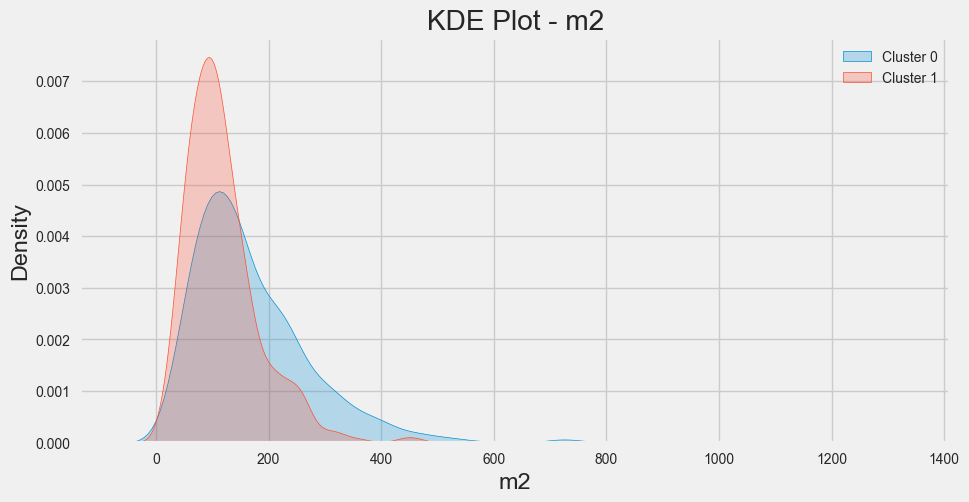

In [121]:
plot_clusters('m2', [df_0, df_1], num_features_plot, (10,5))

True


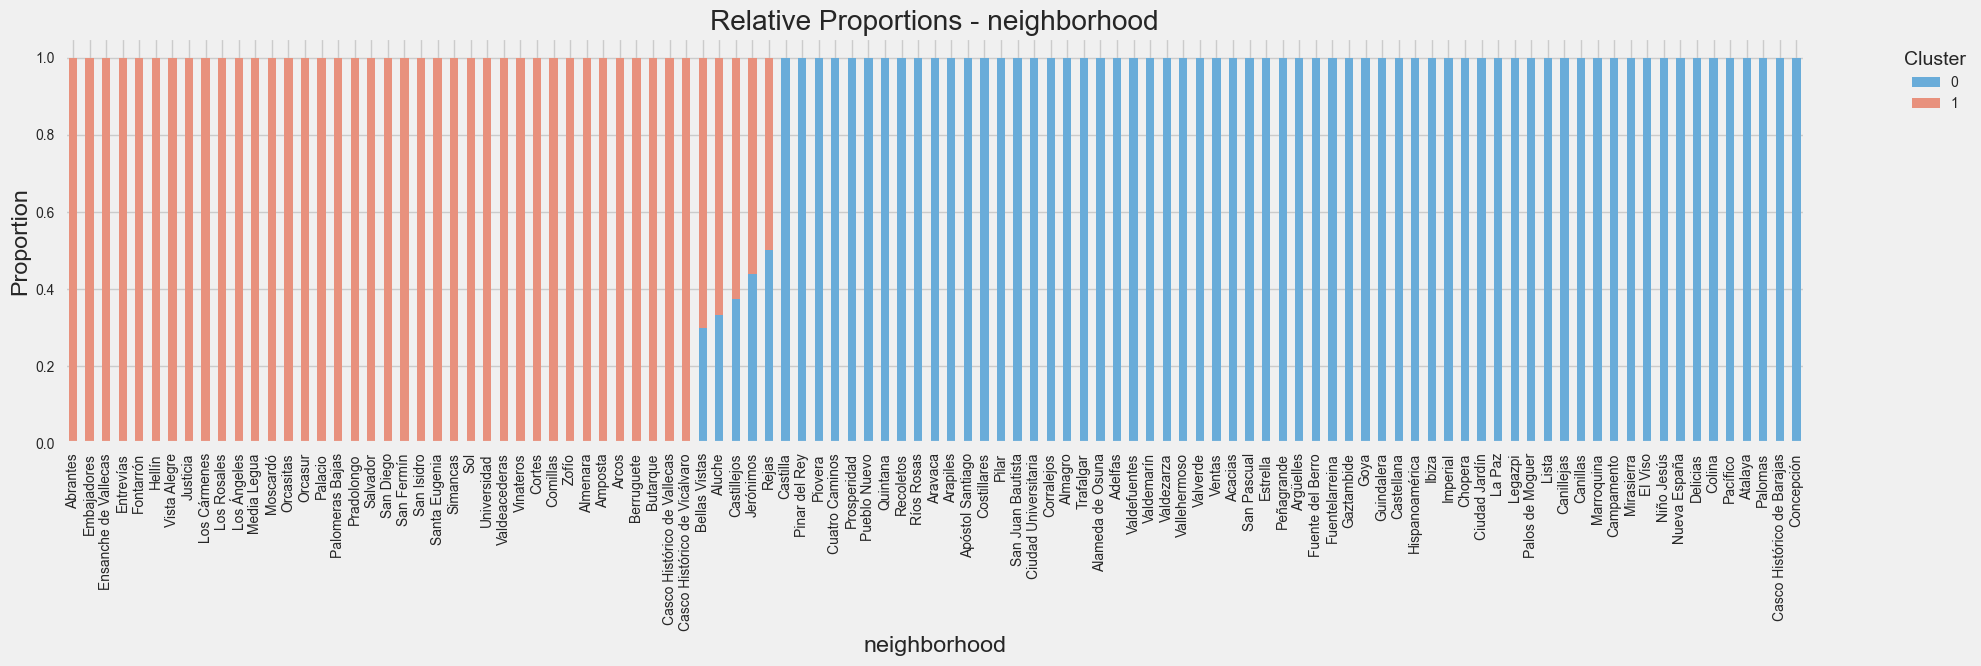

In [122]:
plot_clusters('neighborhood', [df_0, df_1], num_features_plot, (20, 5), True)

In [123]:
df = pd.concat([df_0, df_1], axis=0)

In [124]:
df.to_csv('../data/processed/scraped_data_cleaned_ER_w_cluster_column.csv', index=False)